In [1]:
import process 
import pandas as pd
import numpy as np

# Nail path : '/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DATA_Statapp.csv'
# Jerome path : 'C:\Users\33640\OneDrive\Documents\GitHub\Portfolio_clustering_project\Data\DATA_Statapp.csv'
# Mohamed path : '/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DATA_Statapp.csv'
df = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DATA_Statapp.csv')

# Apply conversion function to 'open' and 'close' columns
df['open'] = df['open'].apply(process.safe_literal_eval)
df['close'] = df['close'].apply(process.safe_literal_eval)

# Calculate returns for each line
df['return'] = df.apply(lambda row: [(close - open) / open for open, close in zip(row['open'], row['close'])], axis=1)

new_df = df[['ticker', 'return']] # create a new data frame with the column ticker and return 

# Créons le DataFrame à partir des listes dans 'return'
# On suppose ici que 'new_df' est déjà défini et contient la colonne 'return'

# Convertir chaque liste dans la colonne 'return' en plusieurs colonnes dans le nouveau DataFrame
returns_df = pd.DataFrame(new_df['return'].tolist())

# Ajouter la colonne 'ticker' du 'new_df' au début de 'returns_df'
returns_df.insert(0, 'ticker', new_df['ticker'])

# Renommer les colonnes pour refléter qu'elles sont des rendements
returns_df.columns = ['ticker'] + [f'return_{i}' for i in range(len(returns_df.columns) - 1)]

df_cleaned = process.remove_rows_with_nan(returns_df)
df_cleaned.reset_index(drop=True, inplace=True)

process.check_nan_inf(df_cleaned)

df_cleaned.set_index('ticker', inplace=True) ## ces deux lignes sont fondamentales, ne pas les retirer !!
df.set_index('ticker', inplace=True)

There are no NaN values in the dataframe


In [40]:
import warnings
from tqdm import tqdm 

warnings.filterwarnings("ignore") ## so that there are no polluting warnings as output of this cell

lookback_window = [5000, 5250]
number_of_clusters = 15
sigma = 5
clustering_method = 'SPONGE' 
number_of_repetition = 20
evaluation_window = 14

overall_return = pd.DataFrame()
PnL1 = []
PnL2 = []

for i in tqdm(range(1, 16)):

    consolidated_W = process.consolidated_W(number_of_repetitions=number_of_repetition, lookback_window=lookback_window, df_cleaned=df_cleaned, number_of_clusters=number_of_clusters, sigma=sigma, df=df)

    portfolio_return = process.portfolio_returns(evaluation_window=evaluation_window, df_cleaned=df_cleaned, lookback_window=lookback_window, consolidated_W=consolidated_W)

    overall_return = pd.concat([overall_return, portfolio_return])

    lookback_window = [lookback_window[0] + evaluation_window*i, lookback_window[1] + evaluation_window*i]

    PnL2.append(np.cumprod(1 + portfolio_return) - 1) 

    if i == 1: 
        PnL1 = np.concatenate((PnL1, np.reshape(np.cumprod(1 + portfolio_return) - 1, (evaluation_window,))))

    else: 
        PnL1 = np.concatenate((PnL1, np.reshape(np.cumprod(1 + portfolio_return) - 1 + PnL1[-1], (evaluation_window,))))
        

 27%|██▋       | 4/15 [04:56<13:34, 74.07s/it]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/khelifanail/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/q2/wg5gyfhj2r9cd97zfmckktvw0000gn/T/ipykernel_66099/3922065789.py", line 19, in <module>
    consolidated_W = process.consolidated_W(number_of_repetitions=number_of_repetition, lookback_window=lookback_window, df_cleaned=df_cleaned, number_of_clusters=number_of_clusters, sigma=sigma, df=df)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Code/process.py", line 529, in consolidated_W
    consolidated_W = pd.DataFrame(index=df_cleaned.index, columns=['weight'])
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

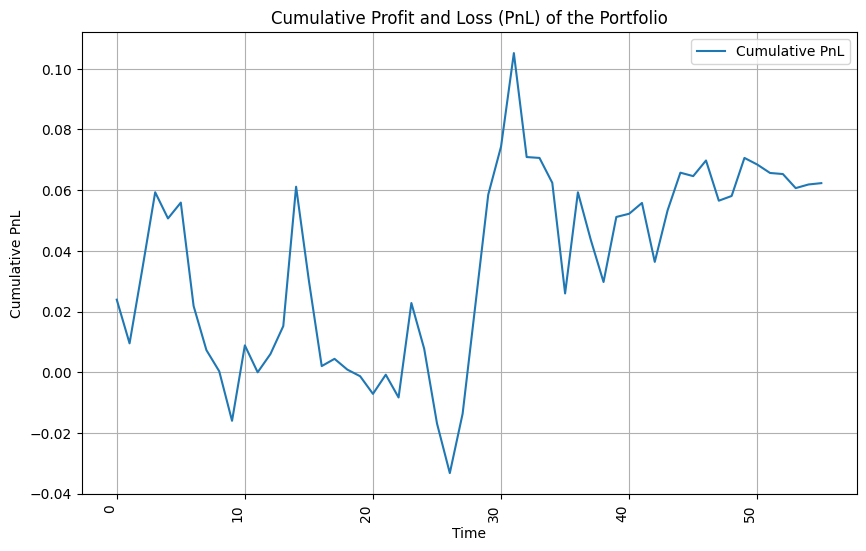

In [42]:
import matplotlib.pyplot as plt 

# Tracé du PnL cumulatif
plt.figure(figsize=(10, 6))
plt.plot(PnL1, label='Cumulative PnL')
plt.title('Cumulative Profit and Loss (PnL) of the Portfolio')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)

plt.xticks(rotation=90, ha='right')

plt.show()


In [27]:
# Calculate the Sharpe ratio (assuming a risk-free rate of 0 for simplicity)
sharpe_ratio = overall_return.mean() / overall_return.std()
sharpe_ratio

portfolio return    0.159931
dtype: float64